[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is an optimization algorithm used to find the local minimum of a function. It is commonly used in many different machine learning algorithms. In this blog post, I will explain the principles behind gradient descent using Python, starting with a simple example of how gradient descent can be used to find the local minimum of a quadratic equation, and then progressing to applying gradient descent to linear regression. By the end of the post, you should be able to code your own version of gradient descent and understand the concept behind it.

In [1]:
# loading necessary libraries and setting up plotting libraries
import numpy as np
import seaborn as sns

import bokeh.plotting as bp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from sklearn.datasets.samples_generator import make_regression 
from scipy import stats 
from bokeh.models import  WheelZoomTool, ResetTool, PanTool
from JSAnimation import IPython_display

W = 590
H = 350
bp.output_notebook()

%matplotlib inline

Loading BokehJS ...

## Minimizing a quadratic equation

To start, let's suppose we have a simple quadratic function, $ f(x) = x^2 − 6x + 5$, and we want to find the minimum of this function. There are plenty of possible reasons why you would want to find the minimum: For example, an object (like a hot air balloon) might be falling down a certain amount of time, before rising again. You want to find out the lowest height of the balloon to make sure you don't accidentally crash into the ground. We can solve this analytically using calculus, by finding the derivate and setting it to zero:

$$\begin{align}
f'(x) = 2x - 6 \\
2x - 6  = 0\\
2x = 6\\
x = 3\end{align}$$

By simply plotting the function, we can see that the local minimum is indeed at 3:

In [2]:
# <!-- collapse=True -->

x = np.linspace(-15,21,100)
y = x**2-6*x+5

TOOLS = [WheelZoomTool(), ResetTool(), PanTool()]

s1 = bp.figure(width=W, plot_height=H, 
               title='Local minimum of function',  
               tools=TOOLS)
s1.line(x, y, color="navy", alpha=0.5, line_width=3)
s1.circle(3, -4, size =10, color="orange")
s1.title_text_font_size = '16pt'
s1.yaxis.axis_label_text_font_size = "14pt"
s1.xaxis.axis_label_text_font_size = "14pt"


bp.show(s1)

/home/cloves/anaconda2/lib/python2.7/site-packages/bokeh/models/plots.py:711: UserWarning: 
    Plot property 'title_text_font_size' was deprecated in 0.12.0 and will be removed. Use 'Plot.title.text_font_size' instead.
    
  warnings.warn(DEP_MSG_0_12_0 % ('title_text_font_size', 'Plot.title.text_font_size'))


We can also find the local minimum with gradient descent - it's an iterative function using the steepest descent. To find the local minimum, you start at a random point, and move into the direction of steepest descent relative to the gradient, i.e. into the direction that goes down (hence, *descent*). In this example, let's suppose we start at $x = 15$. The gradient at this point is $2 \times 15 - 6 = 24$. Because we're using gradient *descent*, we need to subtract the gradient from our $x$-coordinate. However, notice that $16 - 25$ gives us $-9$, clearly overshooting over target of $-3$. To fix this, we multiply the gradient by a *step size*. This step size (often called alpha) has to be chosen carefully, as a value too small will result in a long computation time, while a value too large will not give you the right result (by overshooting) or even fail to converge. In this example, we'll set the step size to 0.01, which means we'll subtract $24 \times 0.01$ from 15, which is $14.76$. This is now our new temporary local minimum: We continue this method until we either don't see a change after we subtracted the gradient * step size, or until we've completed a pre-set number of iterations. 

Below, I've coded this algorithm in Python. The algorithm stops when the values between the new and the temporary minimum do not differ by more than 0.001 - if we need more precision, we can decrease this value. According to gradient descent, the local minimum occurs at $3.05$, which is not too far off from the true local minimum.

In [3]:
old_min = 0
temp_min = 15
step_size = 0.01
precision = 0.001
 
def f_derivative(x):
    return 2*x -6

mins = []
cost = []

while abs(temp_min - old_min) > precision:
    old_min = temp_min 
    gradient = f_derivative(old_min) 
    move = gradient * step_size
    temp_min = old_min - move
    cost.append((3-temp_min)**2)
    mins.append(temp_min)
 
print("Local minimum occurs at {}.".format(round(temp_min,2)))

Local minimum occurs at 3.05.


We can visualize the gradient descent by plotting all temporary local minima on the curve. As you can see, the improvement decreases over time; at the end, the local minimum barely improves.


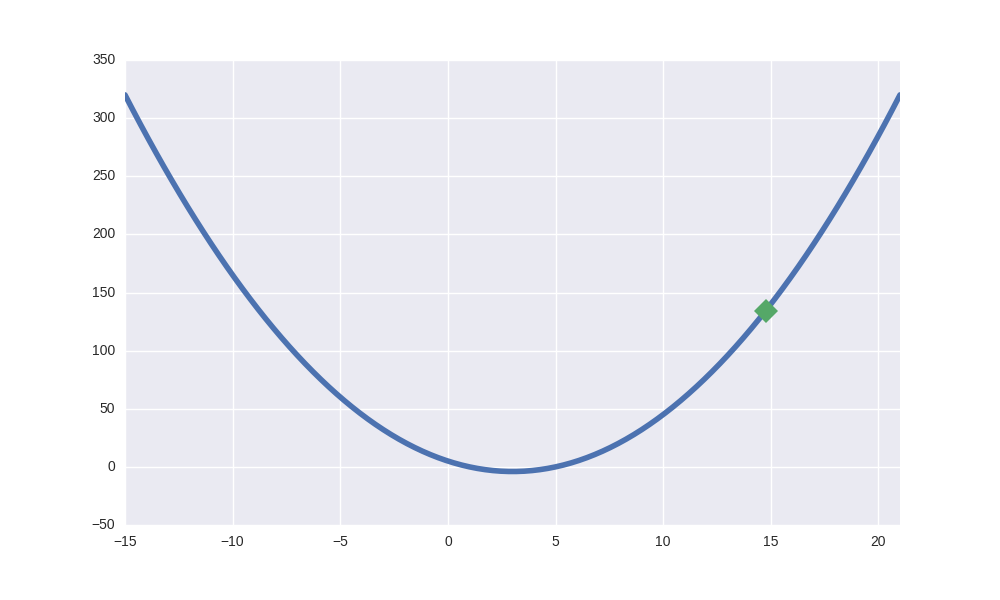
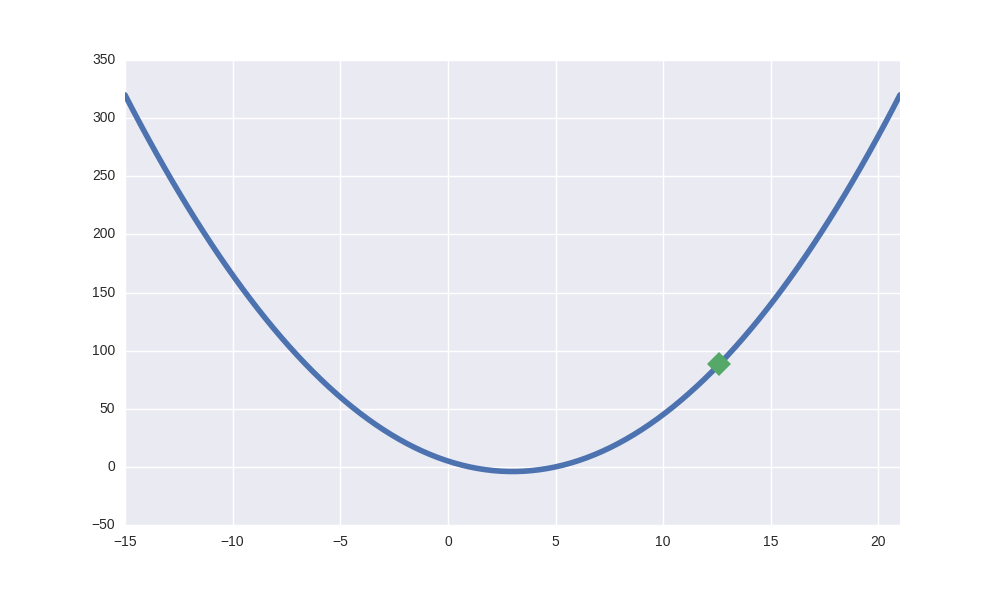
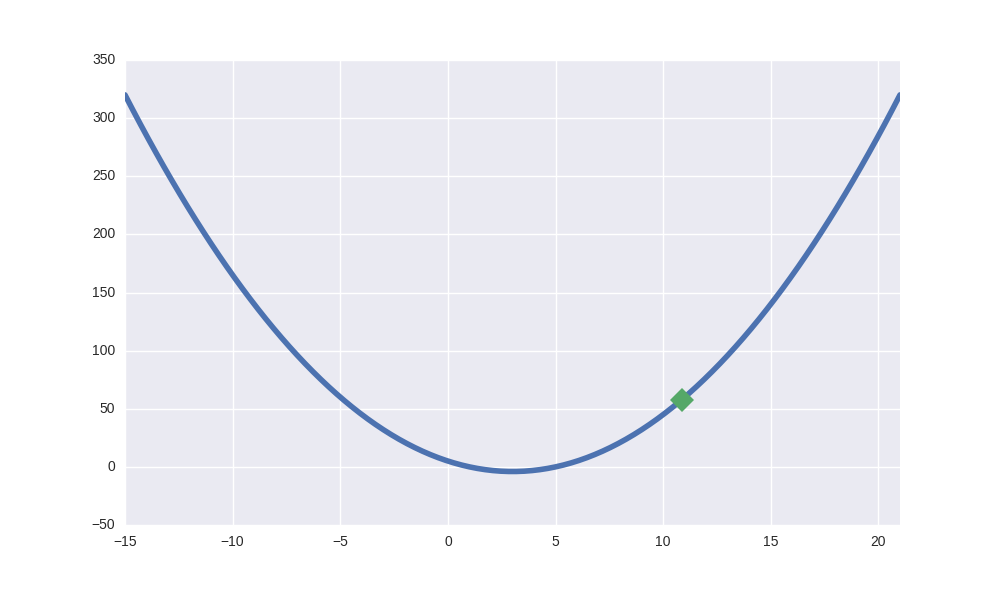
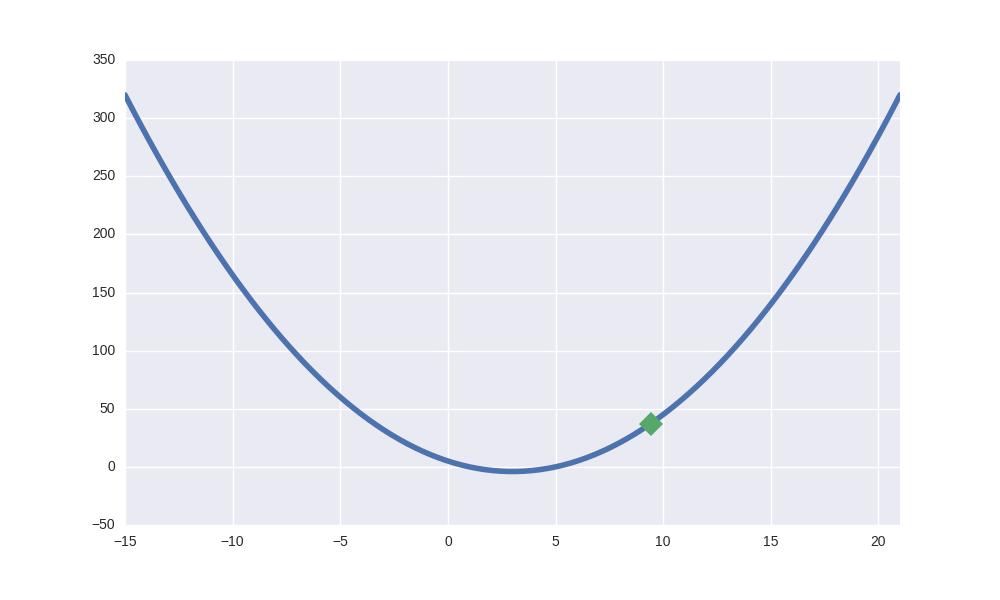
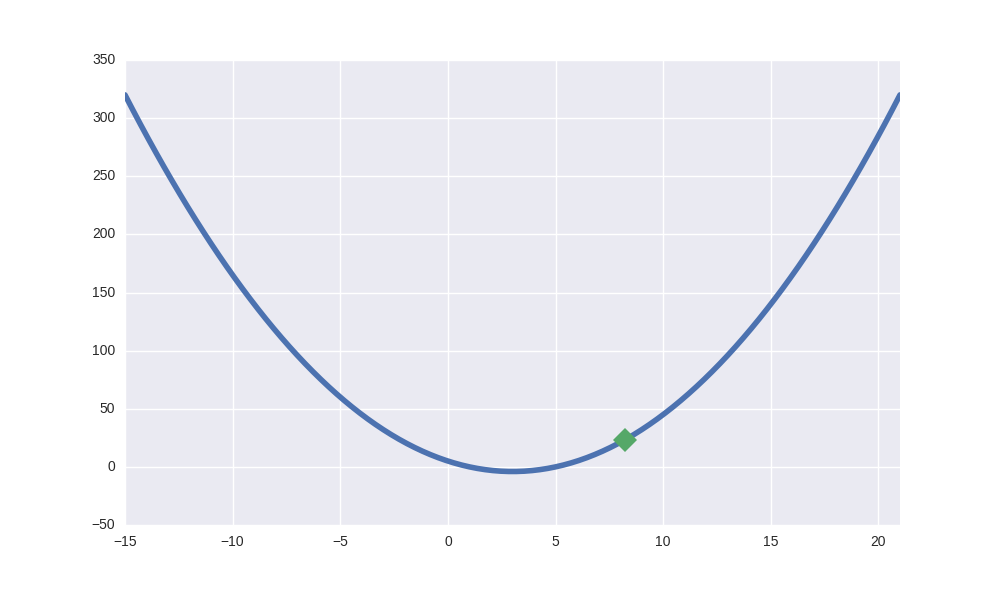
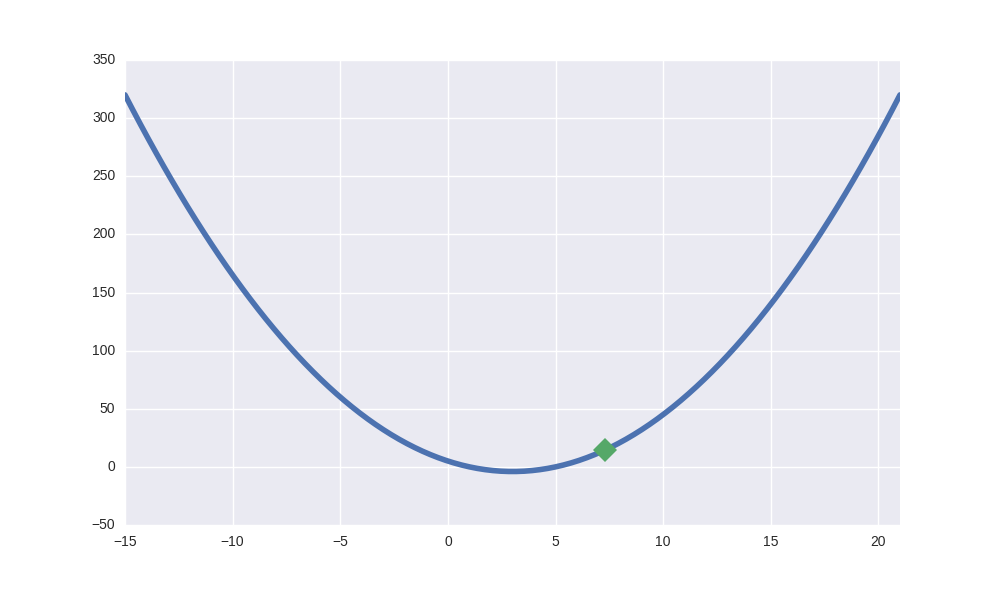
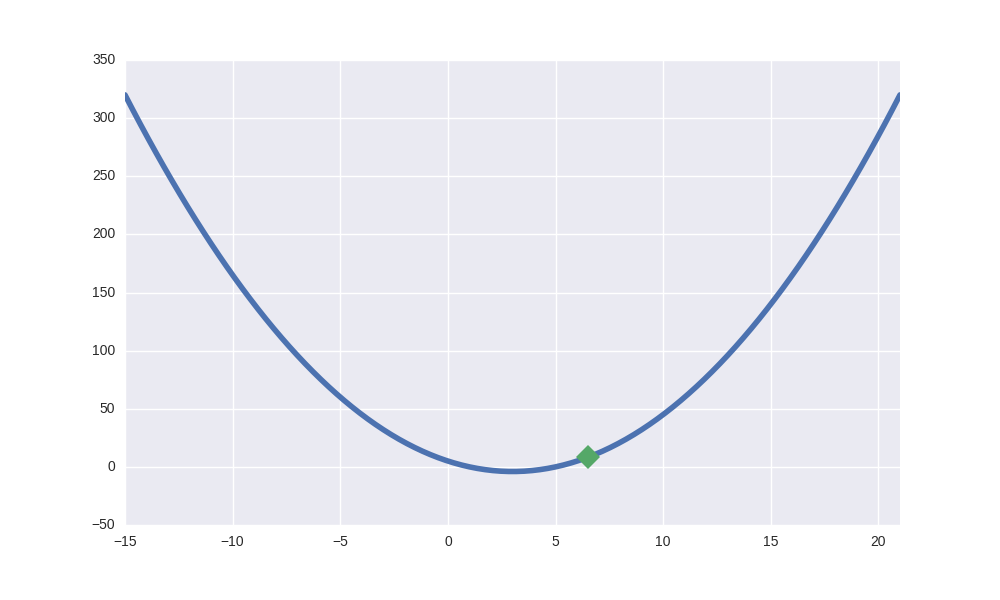
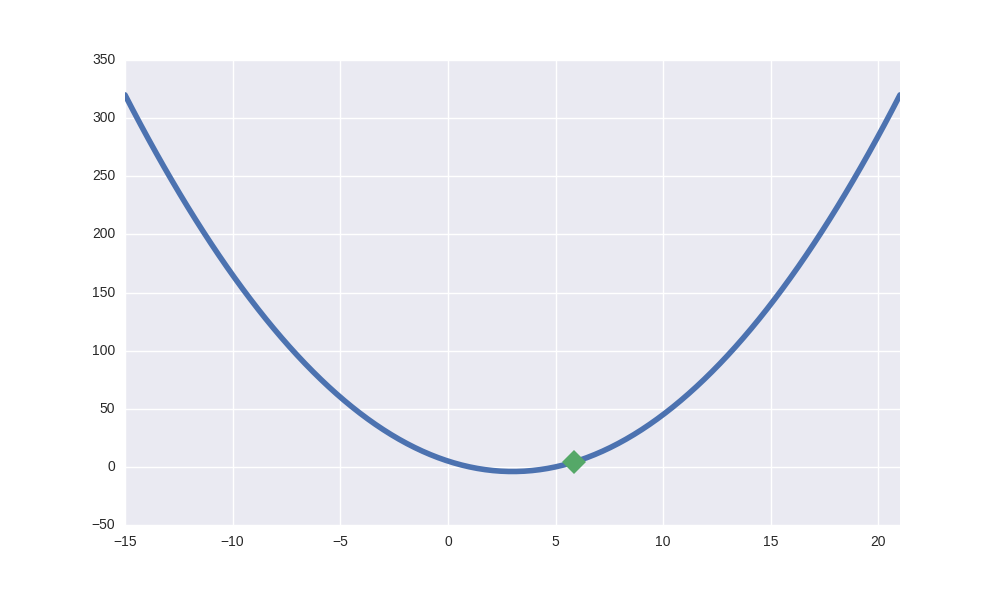
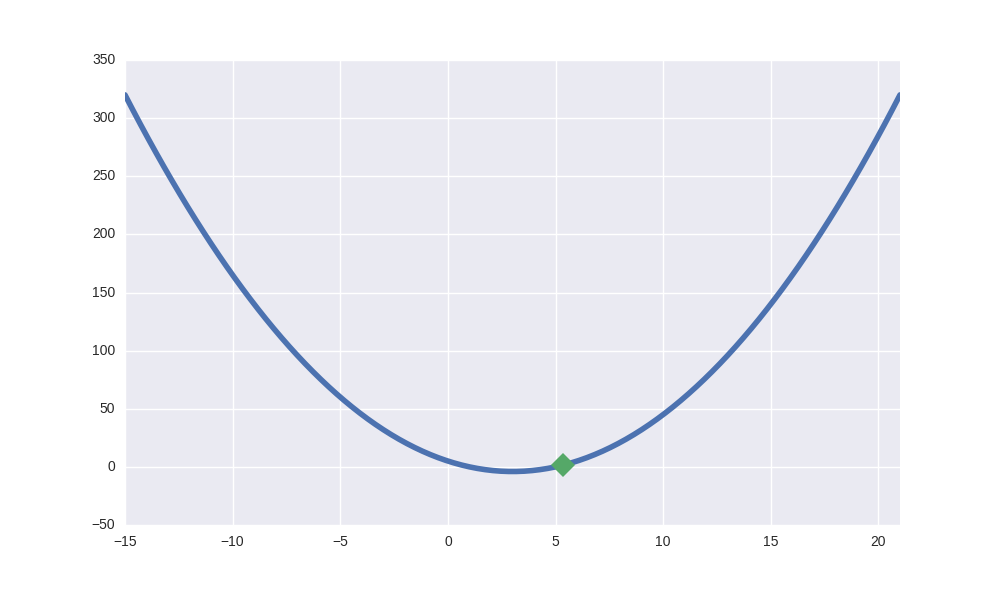
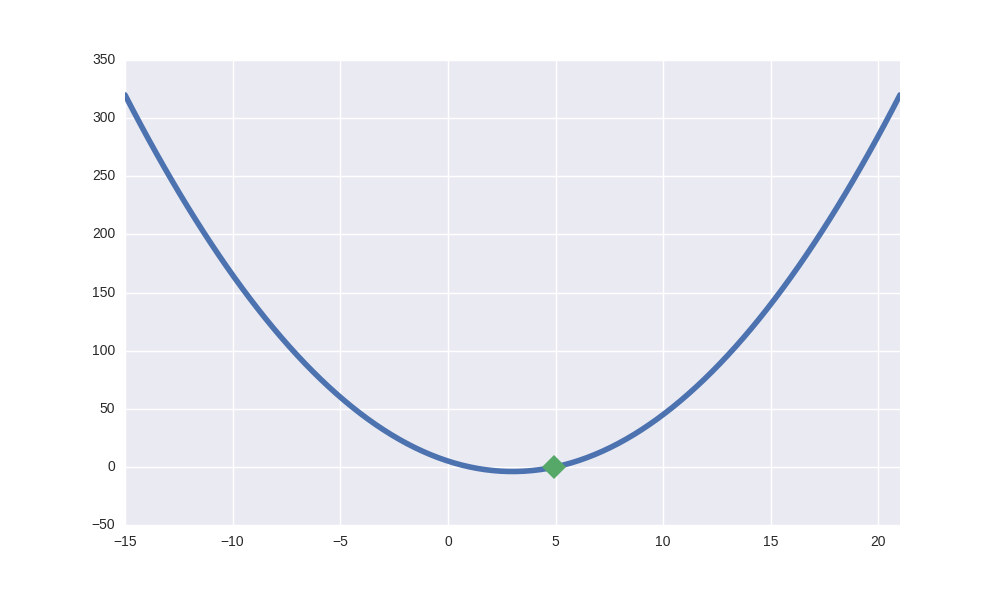
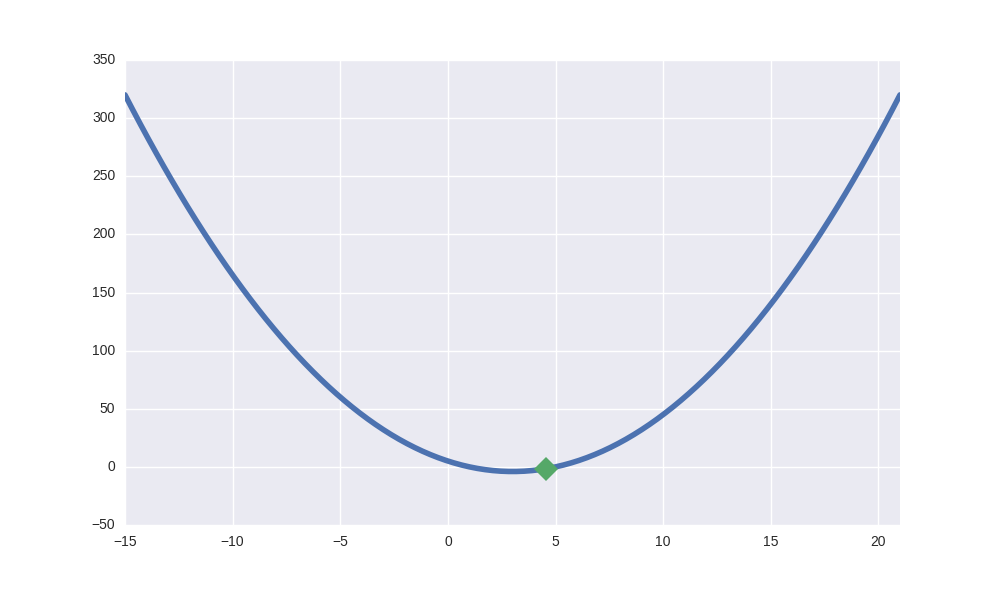
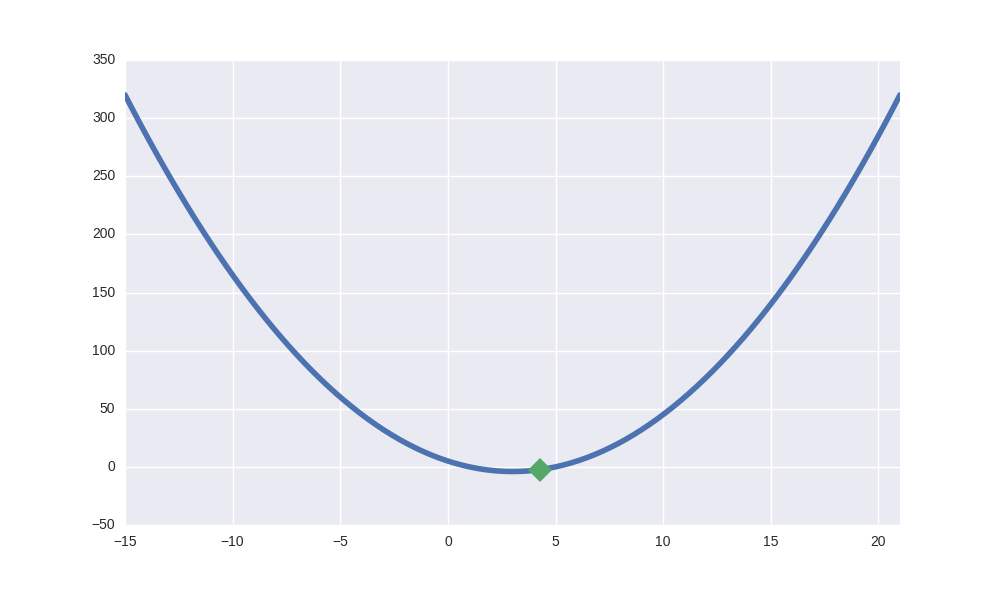
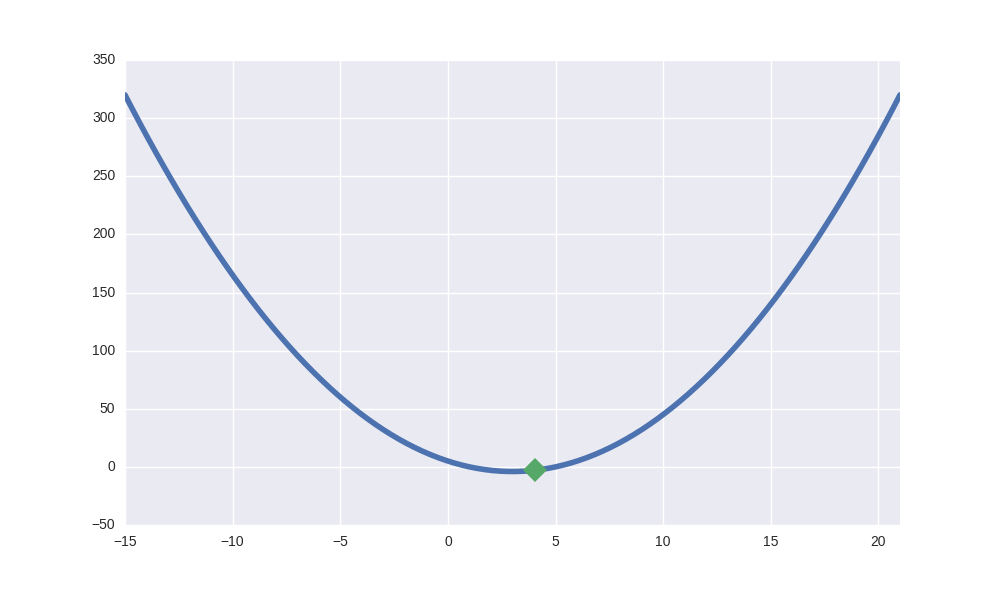
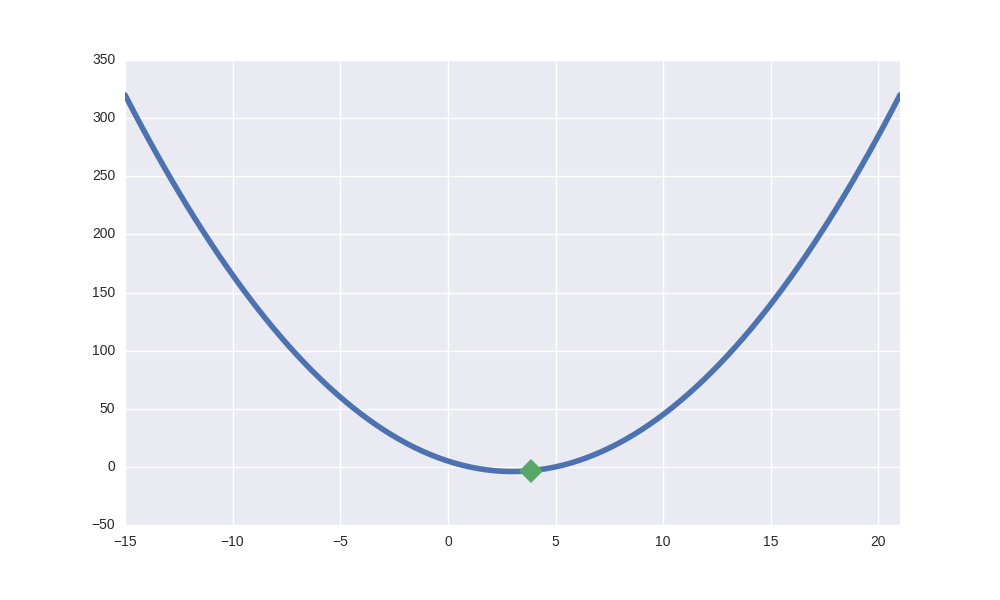
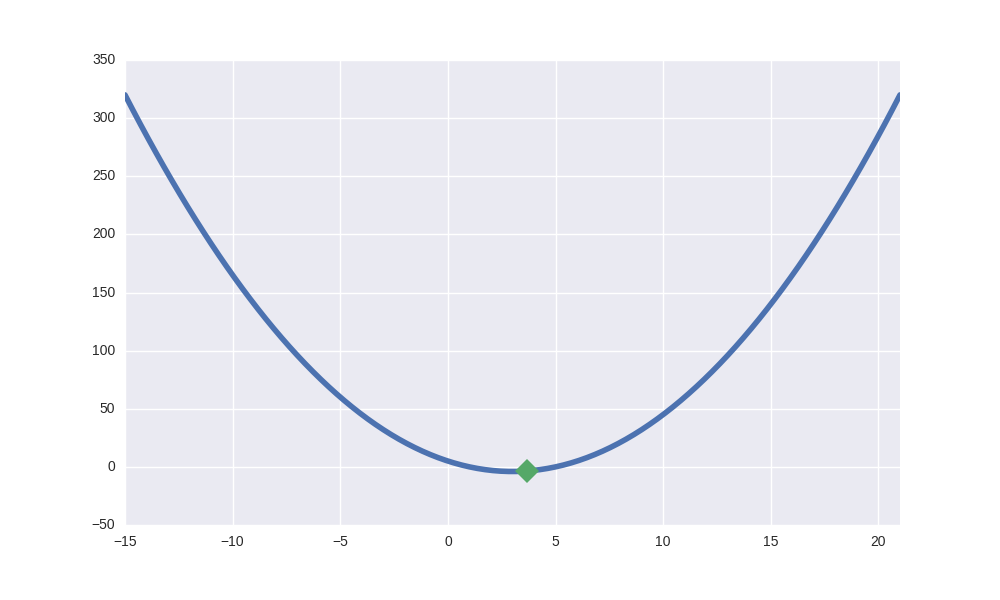
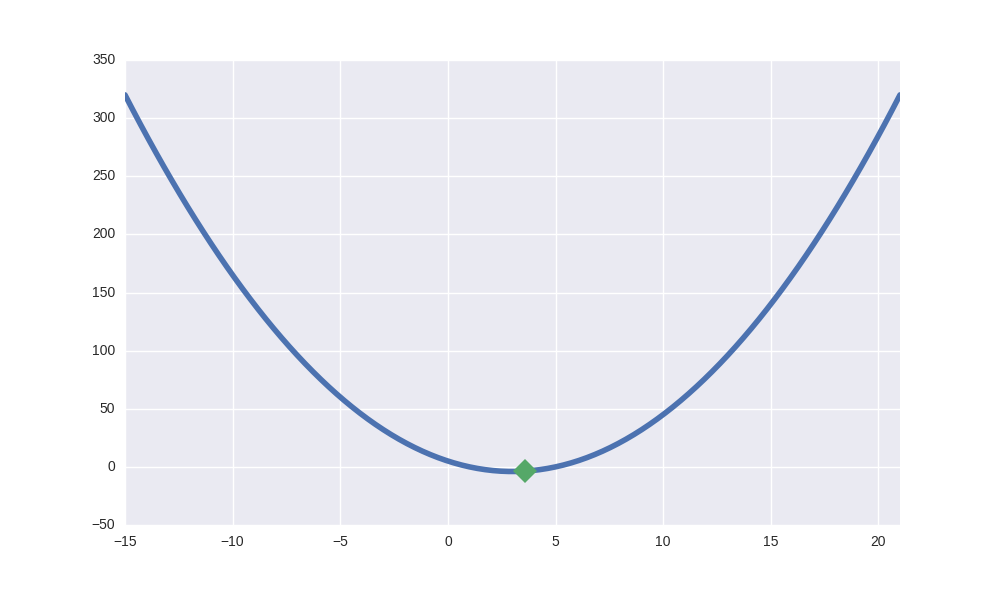
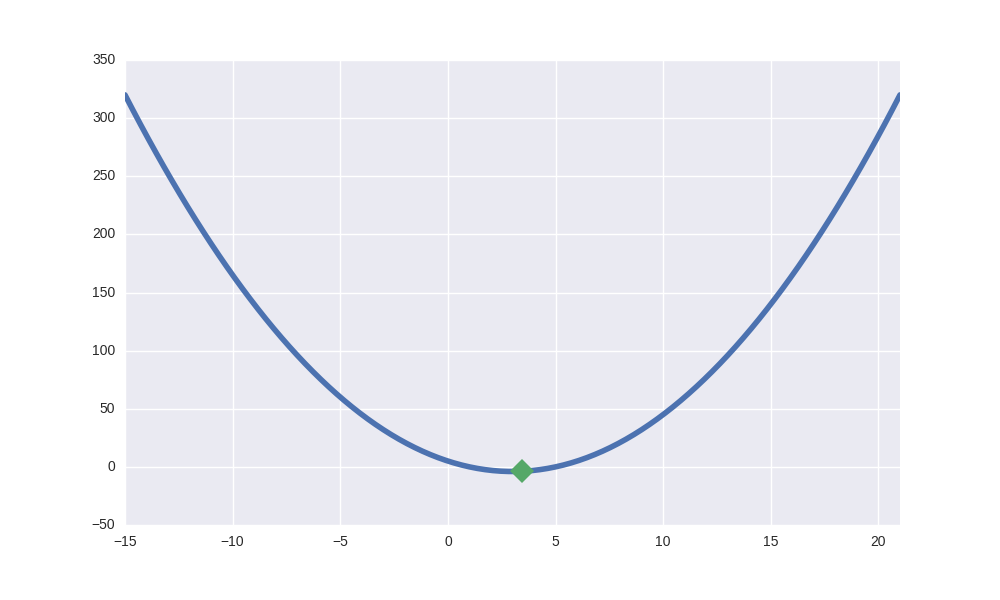
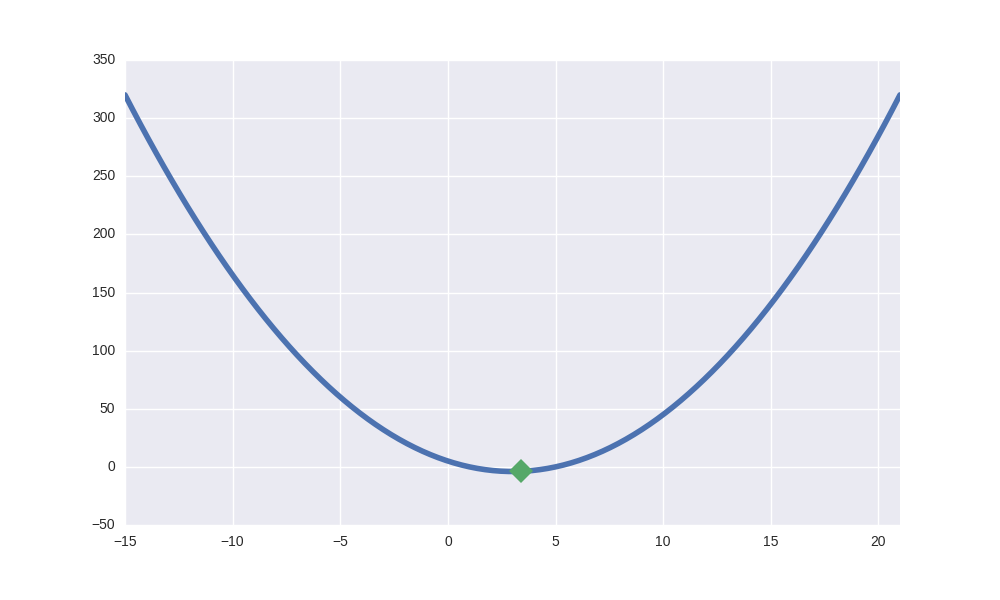
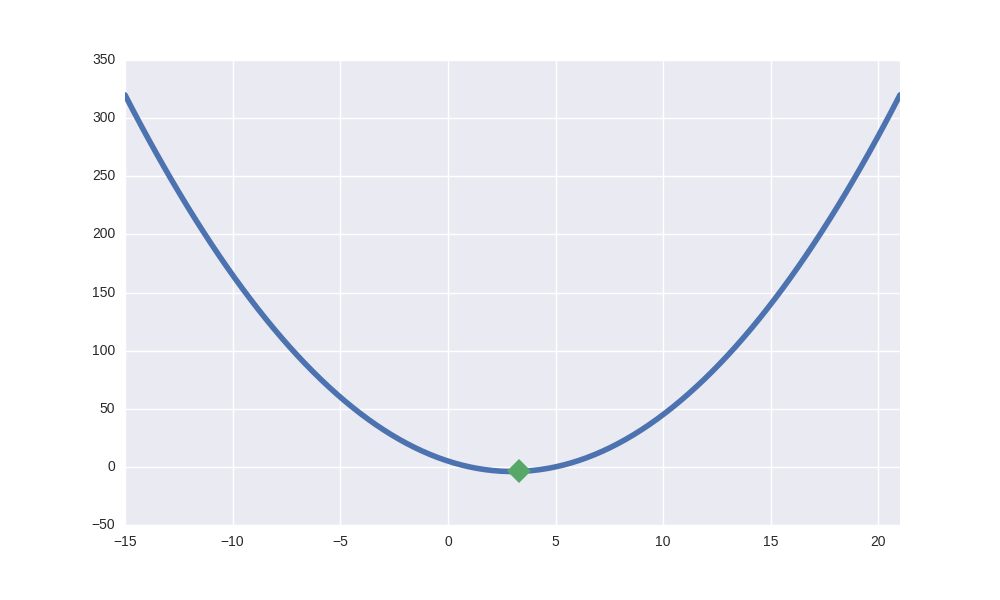
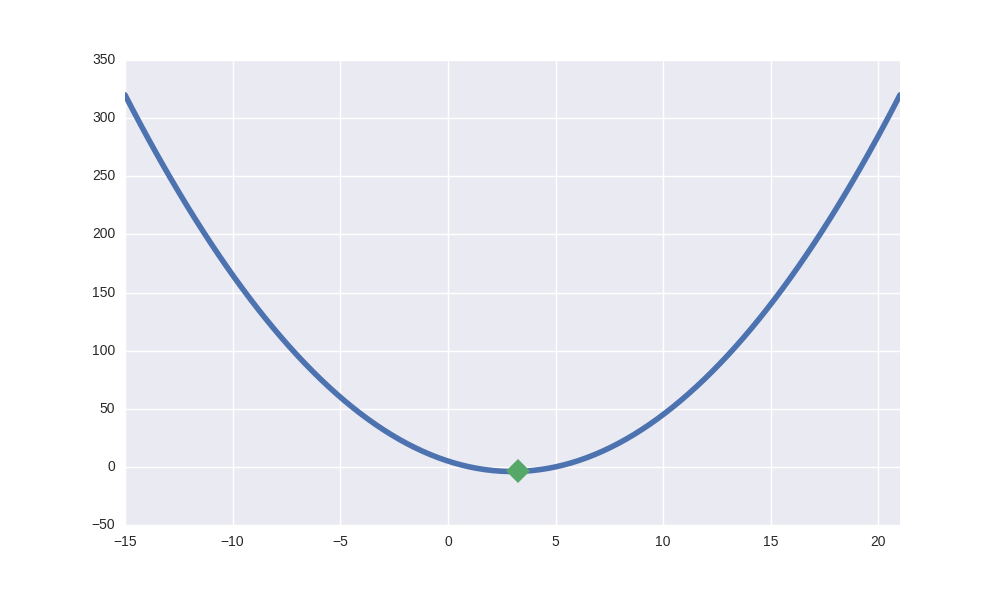
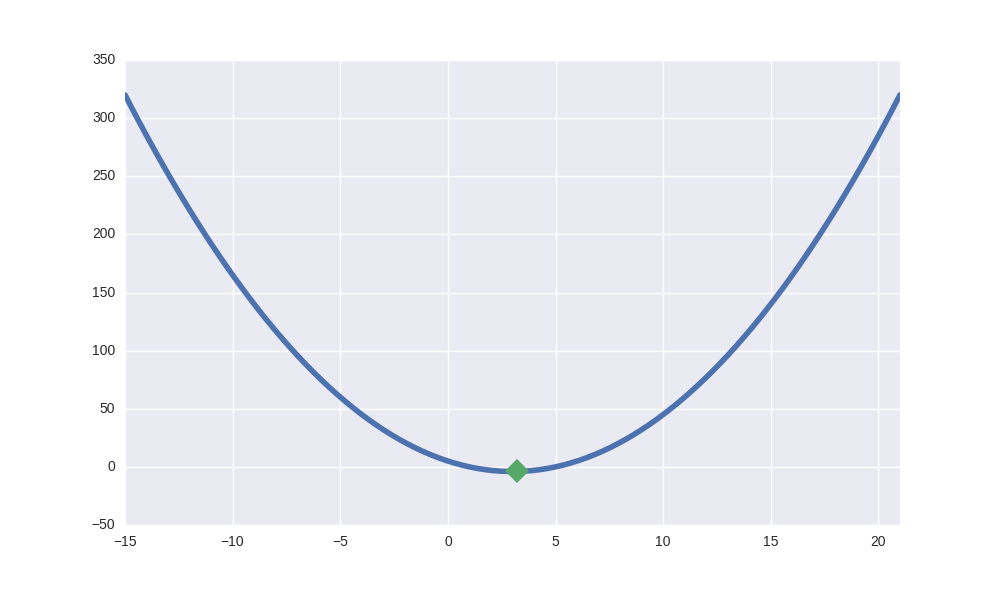
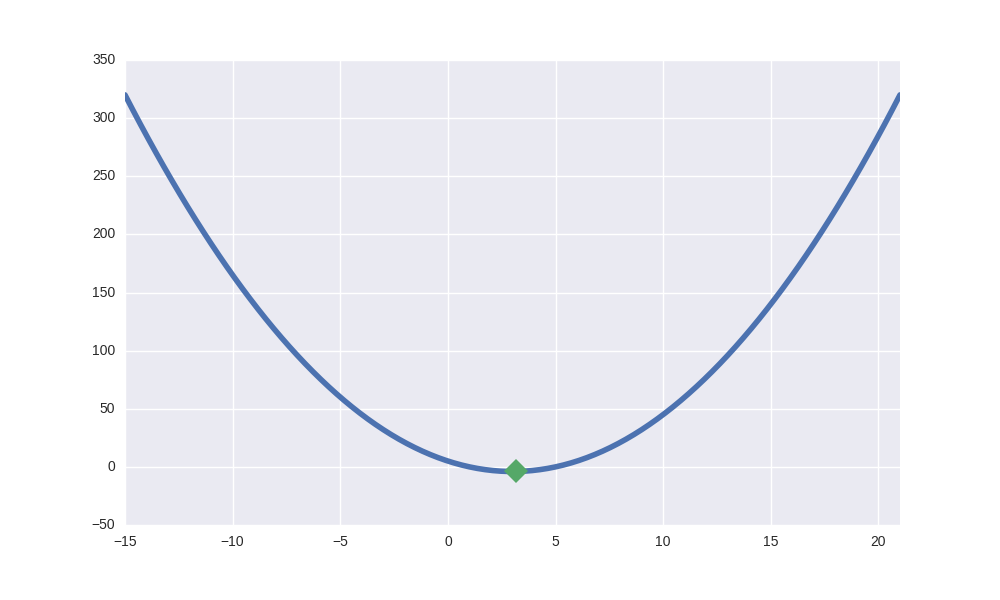
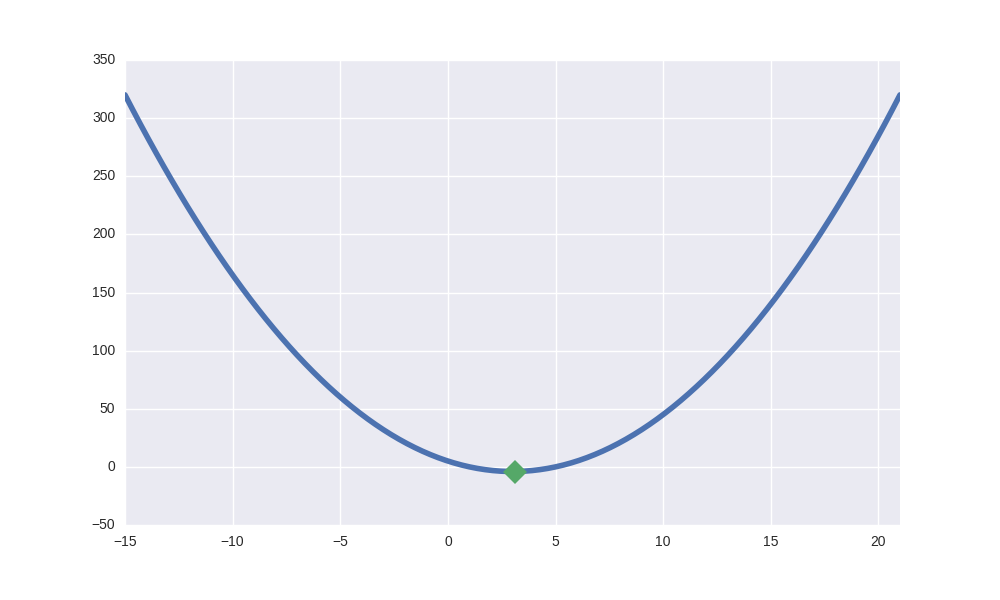
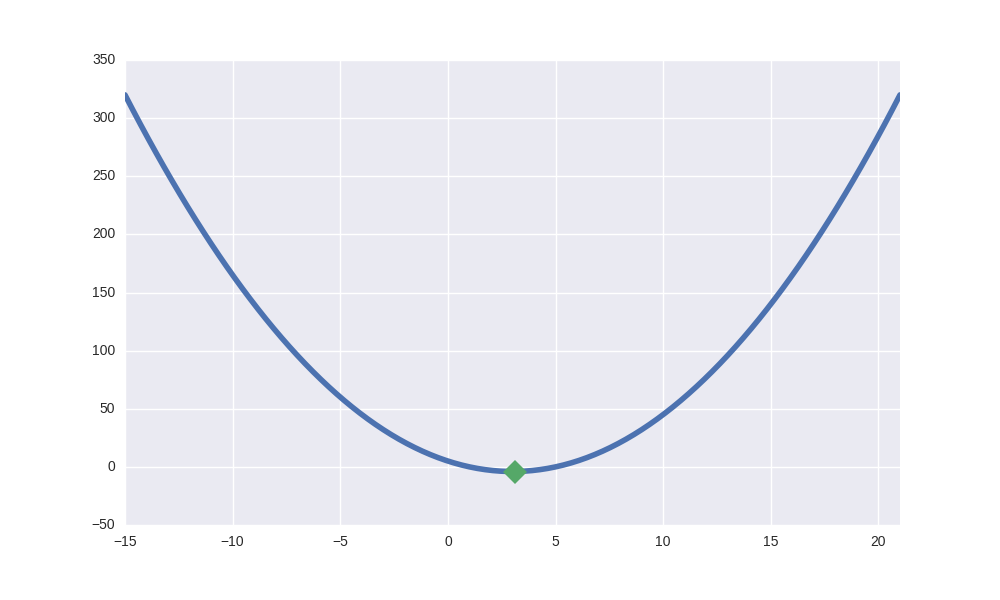
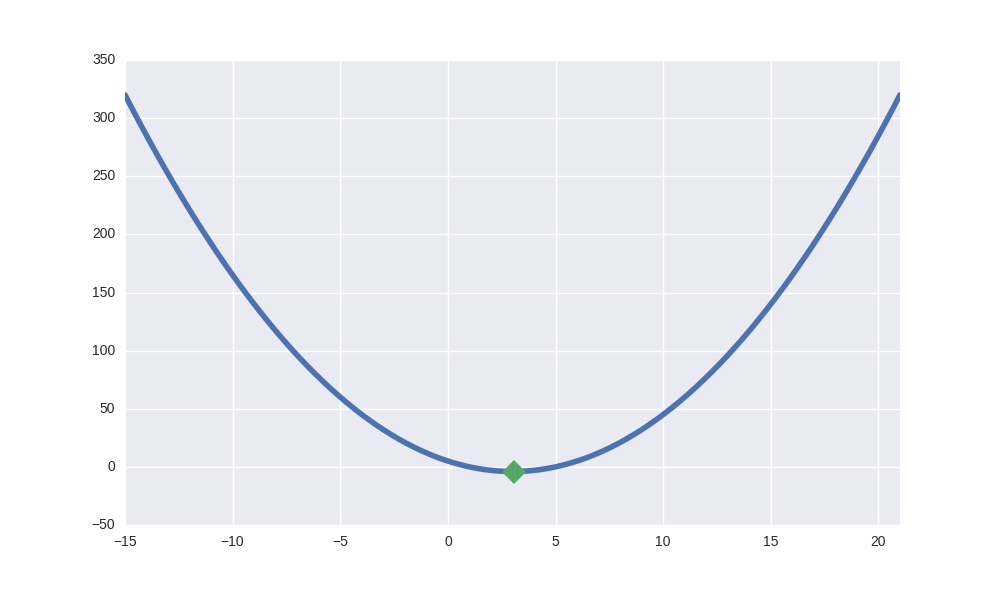
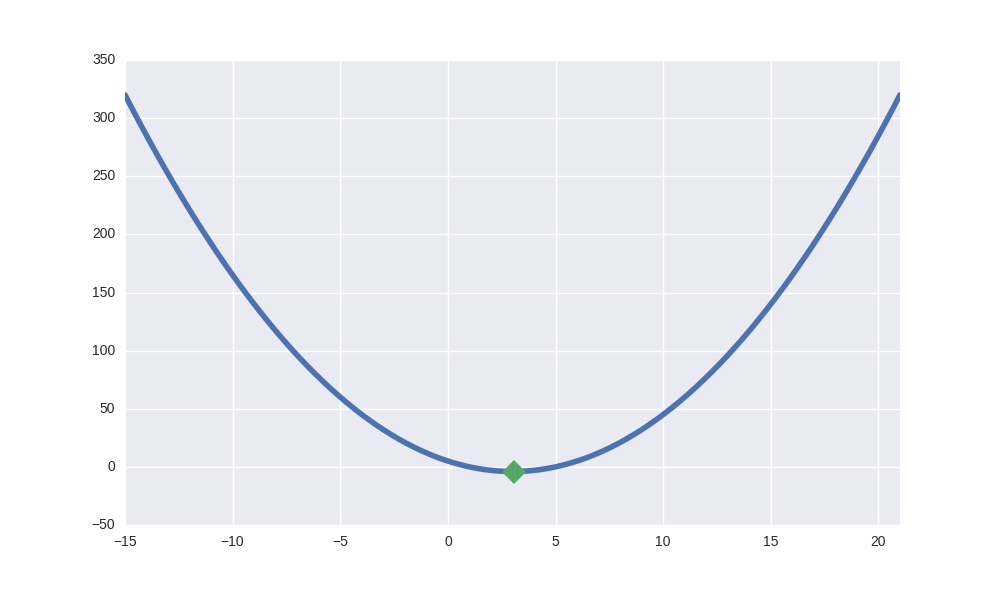
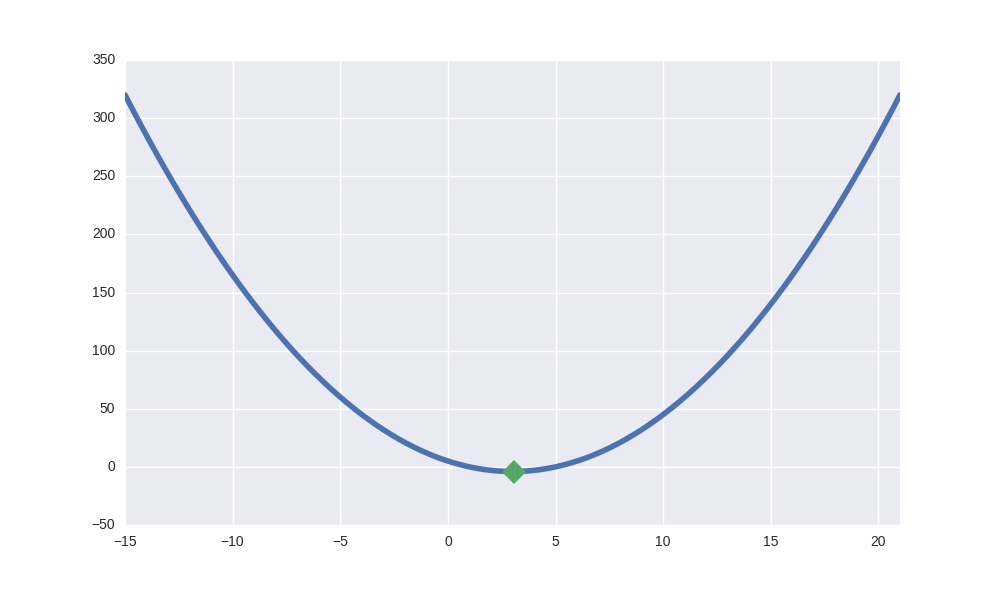
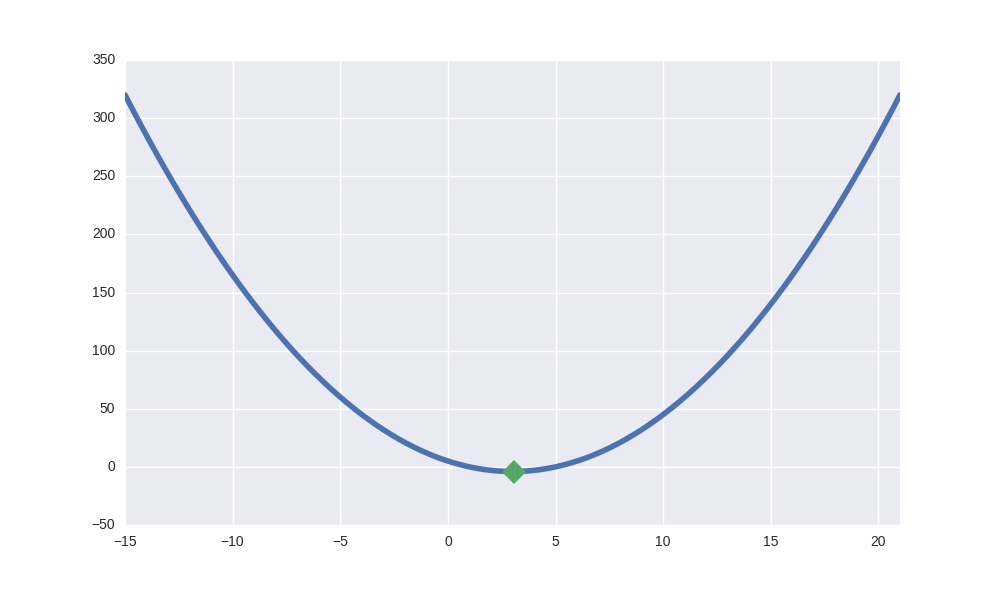

In [4]:
# <!-- collapse=True -->

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x_n = mins[0::10][i]
    y_n = x_n**2-6*x_n+5
    line.set_data(x_n, y_n)
    return line,

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(-15, 21), ylim=(-50, 350))
ax.plot(x,y, linewidth=4 )
line, = ax.plot([], [], "D", markersize=12)
animation.FuncAnimation(fig, animate, init_func=init,
                        frames=len(mins[0::10]), interval=200)

Another important visualization of gradient descent is that there should be a visible improvement over time: In this example, I simply plotted the squared distance from the local minima calculated by gradient descent and the true local minimum against the iteration during which it was calculated. As we can see, the distance gets smaller over time, but barely changes in later iterations. This measure of distance is often called the *cost* or *loss*, but the implementation differs depending on what function you're trying to minimize. 

In [5]:
# <!-- collapse=True -->


TOOLS = [WheelZoomTool(), ResetTool(), PanTool()]


x, y = (zip(*enumerate(cost)))
s1 = bp.figure(width=W, 
               height=H, 
               title='Squared distance to true local minimum',  
#                title_text_font_size='14pt', 
               tools=TOOLS,
               x_axis_label = 'Iteration',
               y_axis_label = 'Distance'
)
s1.line(x, y, color="navy", alpha=0.5, line_width=3)
s1.title_text_font_size = '16pt'
s1.yaxis.axis_label_text_font_size = "14pt"
s1.xaxis.axis_label_text_font_size = "14pt"


bp.show(s1)

## Linear regression

Hopefully, the previous section gave you the basic understanding of gradient descent. In this section, we'll apply the same concept to *linear regression* in order to find line coefficients that fit the data well.

Let's make up some data with noise and plot the resulting data. In this example, it doesn't really matter what the data represent - it could be any two variables that are related to each other, like the height and weight of a person. Additionally, I calculated the line of best fit through the least squares implementation in the `scipy` package, in order to compare the results from gradient descent to the line of best fit. As in our first example, we will use this solution to test how well gradient descent performs.

In [6]:
x, y = make_regression(n_samples = 100, 
                       n_features=1, 
                       n_informative=1, 
                       noise=10,
                       random_state=2015)


slope, intercept, _,_,_ = stats.linregress(x[:,0],y)
best_fit = x[:,0] * slope + intercept

In [7]:
# <!-- collapse=True -->
source = bp.ColumnDataSource(
        data=dict(
            x=x.flatten(),
            y=y        )
    )


TOOLS = [ WheelZoomTool(), ResetTool(), PanTool()]

fig = bp.figure(width=W, height=H, 
                title='Linear Regression Data',  
                title_text_font_size='14pt', 
                tools=TOOLS )
s1 = fig.circle('x', 'y', size=10, color='navy', alpha=0.5, source=source)
s2 = fig.line(x.flatten(), best_fit, color='orange', line_width=3)

fig.title_text_font_size = '16pt'
fig.yaxis.axis_label_text_font_size = "14pt"
fig.xaxis.axis_label_text_font_size = "14pt"

bp.show(fig)

From the plot, you can see that there is a linear relation between the two variables. Let's calculate the regression line through gradient descent. From the example above, we know that we need two things to do so:

* a cost function.
* a way to minimize the cost by updating our parameters (update function)

For a simple regression, we have two parameters: the slope and the intercept. In this example, we express both by the vector $\theta$ with length 2. To find the best line, we have to iteratively find the values of theta that minimize the cost. While in the first example, we defined the cost simple as the squared distance from the true minimum, the cost function $J(\theta)$ for linear regression is a little more complex and defined as follows: 

$$\begin{align}
J(\theta) =  \frac{1}{2m}(X\theta-y)^{T}(X\theta-y)
\end{align}$$

which translates as: For the current $\theta$, predict the $y$ values, and subtract the actual $y$ value. Then square this error ($X\theta-y$). This measures how far away the predicted values are from the actual value of $y$. The overall cost is scaled by $m$, the number of data points we have in $y$, in our example 100.

To minimize this cost function, the theta values have to changed accordingly. The update function is defined as:

$$\begin{align}
\theta := \theta - \alpha \frac{1}{m} (X^{T}(X\theta-y))
\end{align}$$

Theta is adjusted relative to the error of our predicted values, and then scaled by $m$. $\alpha$ is the step-size: As in the earlier example, this value has to be chosen carefully. If you are interested in the mathematical derivations of these functions, you can read through Andrew Ng's [lecture notes](http://cs229.stanford.edu/notes/cs229-notes1.pdf) on the topic, but for this example it suffices to know that they derive on partial derivatives, and thus on the gradient.

Below, the function `gradient_descent` implements the two functions above and adjusts theta iteratively for `iters` iterations. The code is pretty verbose, so you should be able to match the code to the functions above.

In [8]:
def gradient_descent(x, y, iters, alpha):
    costs = []
    m = y.size # number of data points
    theta = np.random.rand(2) # random start
    history = [theta] # to store all thetas
    preds = []
    for i in range(iters):
        pred = np.dot(x, theta)
        error = pred - y 
        cost = np.sum(error ** 2) / (2 * m)
        costs.append(cost)
        
        if i % 25 == 0: preds.append(pred)

        gradient = x.T.dot(error)/m 
        theta = theta - alpha * gradient  # update
        history.append(theta)
        
    return history, costs, preds

We can now call the function on our data. First, we have to insert a column of 1's in order for the matrix algebra to work out. We define the step size and the number of iterations, and then call the function.

In [9]:
x = np.c_[np.ones(x.shape[0]), x] 

In [10]:
alpha = 0.001 # set step-size
iters = 5000 # set number of iterations
history, cost, preds = gradient_descent(x, y, iters, alpha)
theta = history[-1]

Here is the result after 5000 iterations, compared to the values from the least squares algorithm. The results are pretty close, and the line seems to have a good fit:

In [11]:
print("Gradient Descent: {:.2f}, {:.2f}".format(theta[0], theta[1]))
print("Least Squares: {:.2f}, {:.2f}".format(intercept, slope))

Gradient Descent: 1.20, 62.81
Least Squares: 1.49, 63.42


In [12]:
# <!-- collapse=True -->
pred = np.dot(x, theta)

source = bp.ColumnDataSource(
        data=dict(
            x=x[:, 1].flatten(),
            y=y        )
    )


TOOLS = [ WheelZoomTool(), ResetTool(), PanTool()]

fig = bp.figure(width=W, plot_height=H, 
                title='Line fit by gradient descent',  
                title_text_font_size='14pt', 
                tools=TOOLS )
s1 = fig.circle('x', 'y', size=10, color='navy', alpha=0.5, source=source)
s2 = fig.line(x[:, 1].flatten(), pred, color='orange', line_width=3)
fig.title_text_font_size = '16pt'
fig.yaxis.axis_label_text_font_size = "14pt"
fig.xaxis.axis_label_text_font_size = "14pt"


bp.show(fig)

The plot below shows how the values of theta change over time. The random starts sets theta to low values, and then gradient descent adjusts the slope to a much higher value, while changing the intercept at the same time.

In [13]:
# <!-- collapse=True -->
TOOLS = [WheelZoomTool(), ResetTool(), PanTool()]

to_plot = [(x[0],x[1], c) for x, c in  (zip(history[::100], cost[::100]))]
a,b,c = zip(*to_plot)



fig = bp.figure(width=W, plot_height=H, 
                title='Theta values over time',  
                tools=TOOLS,
                x_axis_label='Intercept',
                y_axis_label='Slope')
s1 = fig.circle(a,b, size=5, color='navy', alpha=0.5)
fig.title_text_font_size = '16pt'
fig.yaxis.axis_label_text_font_size = "14pt"
fig.xaxis.axis_label_text_font_size = "14pt"

bp.show(fig)

As in the first example, the cost should decrease over iterations - if it is not, there is something wrong with your update function! Below, we see that the cost is indeed decreasing, and approaching zero. Depending on your data, and how linear it is, the cost will never reach zero but hover around a higher value. To test this, you can increase the `noise` parameter in the `make_regression` function that generated our data.

In [14]:
# <!-- collapse=True -->
TOOLS = [WheelZoomTool(), ResetTool(), PanTool()]
x1, y1 = (zip(*enumerate(cost)))

fig = bp.figure(width=590, plot_height=350, 
                title='Loss over iterations',
                x_axis_label='Iteration',
                y_axis_label='Loss',
                tools=TOOLS )
s1 = fig.line(x1,y1, line_width=4, color='navy', alpha=0.5)
# remaining cost is tied directly to the noise of the distribution,
# ergo it's also a measure of fit
fig.title_text_font_size = '16pt'
fig.yaxis.axis_label_text_font_size = "14pt"
fig.xaxis.axis_label_text_font_size = "14pt"

bp.show(fig)

Below is an animated plot that shows the changing line (green) defined by the theta values over time. It starts with our random thetas close to 0 which results in a horizontal line, and then slowly approaches the line of best fit (red). As evident in the cost plot, the improvement slows down over subsequent iterations and barely changes at the end.

IndexError: too many indices for array

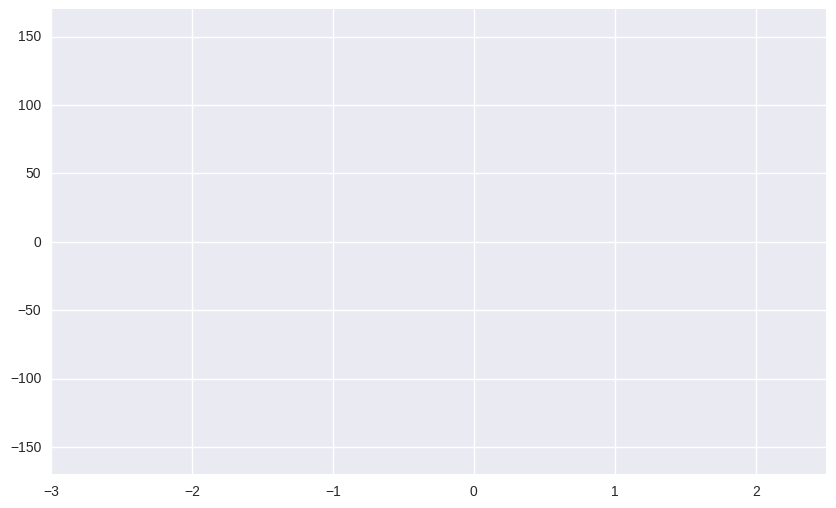

In [17]:
# <!-- collapse=True -->

def animate(i):
    ys = preds[i]
    line.set_data(x[:, 1], ys)
    return line,



fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(-3, 2.5), ylim=(-170, 170))
ax.plot(x[:,1],y, 'o')
line, = ax.plot([], [], lw=2)
plt.plot(x[:,1], best_fit, 'k-', color = "r")

anim = animation.FuncAnimation(fig, animate, init_func=init,
                        frames=len(preds), interval=100)
anim

And that's it: We used gradient descent successfully to find regression parameters that fit our test data! I hope these examples and the code were helpful in explaining both the conceptual background behind gradient descent, and how it can be implemented. As a introductory tutorial, there is a lot I left out, and if you're interested, I recommend checking out Andrew Ng's machine learning [course on Coursera](https://class.coursera.org/ml-003/lecture/9), as well as his [lecture notes](http://cs229.stanford.edu/notes/cs229-notes1.pdf). Additionally, here is a list of blog posts covering gradient descent in Python:

* http://aimotion.blogspot.com/2011/10/machine-learning-with-python-linear.html
* http://spin.atomicobject.com/2014/06/24/gradient-descent-linear-regression/
* http://stackoverflow.com/questions/17784587/gradient-descent-using-python-and-numpy

As you have  probably noticed, there were simpler ways to find the solution to our two problems analytically, but it served as a good showcase to show the effectiveness of gradient descent compared to the analytic solutions. Furthermore, gradient descent is commonly used in neural networks, where you might have to implement it yourself -  check out Andrej Karpathy's [Hacker's guide to Neural Networks
](http://karpathy.github.io/neuralnets/) if you want to know more!

As a last note, I wanted to mention that both examples here only have one minimum, and are [convex functions](https://en.wikipedia.org/wiki/Convex_function). This means that no matter where we start (initial values of theta), we arrive at the minimum. This is not always the case. The plot below shows the convexity of the linear regression example, with the red point denoting the minimum. No matter where on the plane we start, gradient descent works as a compass pointing to the minimum.

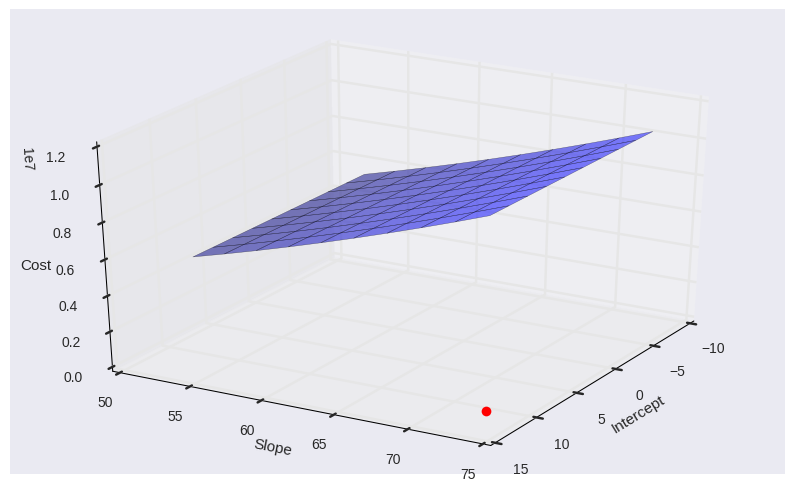

In [18]:
# <!-- collapse=True -->

from mpl_toolkits.mplot3d import Axes3D

def error(X, Y, THETA):
    return np.sum((X.dot(THETA) - y)**2)/(2*Y.size)

ms = np.linspace(theta[0] - 10 , theta[0] + 10, 10)
bs = np.linspace(theta[1] - 10 , theta[1] + 10, 10)

M, B = np.meshgrid(ms, bs)

zs = np.array([error(x, y, theta) 
               for theta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.5)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Cost')
ax.view_init(elev=30., azim=30)
ax.plot([theta[0]], [theta[1]], [cost[-1]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);


PS: This post was written in a Jupyter Notebook. If you'd like to run the code yourself, download the notebook [here](https://github.com/tillbe/pelican-blog/blob/master/content/notebooks/gradient_descent.ipynb).